In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
from scipy.signal import hilbert
from sklearn.base import BaseEstimator, TransformerMixin

class Flatten(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))


In [3]:
from moabb.pipelines.fbcsp_selectandcov import FBCSP_SelectAndCov
from moabb.pipelines.zeropad import ZeroPad
from moabb.pipelines.resample import Resample
from moabb.pipelines.ica import ICA

2021-02-12 03:16:47 phi root[46689] WARNING Choosing from all possible events
2021-02-12 03:16:47 phi root[46689] INFO Processing dataset: 001-2014
2021-02-12 03:16:49 phi root[46689] INFO CSP + LDA | 001-2014 | 1 | session_E: Score 0.957
2021-02-12 03:16:49 phi root[46689] INFO CSP + LDA | 001-2014 | 1 | session_T: Score 0.931
2021-02-12 03:16:52 phi root[46689] INFO CSP + LDA | 001-2014 | 2 | session_E: Score 0.650
2021-02-12 03:16:52 phi root[46689] INFO CSP + LDA | 001-2014 | 2 | session_T: Score 0.527
2021-02-12 03:16:52 phi root[46689] WARNING Choosing from all possible events
2021-02-12 03:16:52 phi root[46689] INFO Processing dataset: 001-2014
2021-02-12 03:17:04 phi root[46689] INFO FBCSP + LDA | 001-2014 | 1 | session_E: Score 0.562
2021-02-12 03:17:12 phi root[46689] INFO FBCSP + LDA | 001-2014 | 1 | session_T: Score 0.566
2021-02-12 03:17:22 phi root[46689] INFO FBCSP + LDA | 001-2014 | 2 | session_E: Score 0.573
2021-02-12 03:17:30 phi root[46689] INFO FBCSP + LDA | 001-20

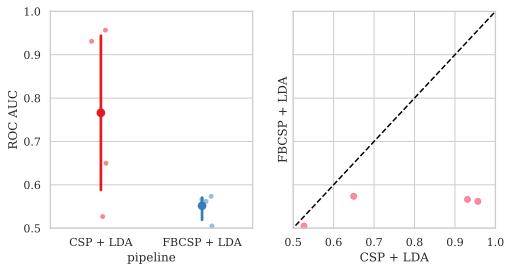

In [7]:
"""
=========================
FilterBank CSP versus CSP
=========================

This Example show a comparison of CSP versus FilterBank CSP on the
very popular dataset 2a from the BCI competition IV.
"""
# Authors: Alexandre Barachant <alexandre.barachant@gmail.com>
#
# License: BSD (3-clause)

import moabb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

from mne.decoding import CSP

from moabb.datasets import BNCI2014001
from moabb.paradigms import MotorImagery
from moabb.evaluations import CrossSessionEvaluation
from moabb.pipelines.utils import FilterBank

moabb.set_log_level('info')

##############################################################################
# Create pipelines
# ----------------
#
# The CSP implementation from MNE is used. We selected 8 CSP components, as
# usually done in the litterature.
#
# The second pipeline is the filter bank CSP. We use the FilterBank object
# with a CSP estimator. We set up the CSP to 4 components, to compensate for
# the higher dimensionality.
#
# The two pipelines will be applied on two different paradigm, so they have
# their own dict.

pipelines = {}
pipelines['CSP + LDA'] = make_pipeline(CSP(n_components=8),
                                       LDA())

pipelines_fb = {}
pipelines_fb['FBCSP + LDA'] = make_pipeline(ICA(n_out=20),
                                            #Resample(new_fs=75),
                                            Flatten(),
                                            LDA())

##############################################################################
# Evaluation
# ----------
#
# Since two different preprocessing will be applied, we have two different
# paradigm objects. We have to make sure their filter matchs so the comparison
# will be fair.
#
# The first one is a standard `LeftRightImagery` with a 8 to 35 Hz broadband
# filter.
#
# The second is a `FilterBankLeftRightImagery` with a bank of 6 filter, ranging
# from 8 to 35 Hz.

# Because this is being auto-generated we only use 2 subjects
dataset = BNCI2014001()
dataset.subject_list = dataset.subject_list[:2]
datasets = [dataset]
overwrite = True  # set to True if we want to overwrite cached results

# broadband filters
fmin = 8
fmax = 35
paradigm = MotorImagery(fmin=fmin, fmax=fmax)
evaluation = CrossSessionEvaluation(paradigm=paradigm, datasets=datasets,
                                    suffix='examples', overwrite=overwrite) # Change to CrossSubject!
results = evaluation.process(pipelines)

# bank of 6 filter, by 4 Hz increment
fmin = 4
fmax = 35
paradigm = MotorImagery(fmin=fmin, fmax=fmax) # BANDPASS IS IMPORTANT BECAUSE WE'RE DOWNSAMPLING!!
evaluation = CrossSessionEvaluation(paradigm=paradigm, datasets=datasets,
                                    suffix='examples', overwrite=overwrite)
results_fb = evaluation.process(pipelines_fb)

###############################################################################
# After processing the two, we simply concatenate the results.

results = pd.concat([results, results_fb])


##############################################################################
# Plot Results
# ----------------
#
# Here we plot the results via normal methods. We the first plot is a pointplot
# with the average performance of each pipeline across session and subjects.
# The second plot is a paired scatter plot. Each point representing the score
# of a single session. An algorithm will outperforms another is most of the
# points are in its quadrant.

fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(data=results, y='score', x='pipeline', ax=axes[0], jitter=True,
              alpha=.5, zorder=1, palette="Set1")
sns.pointplot(data=results, y='score', x='pipeline', ax=axes[0],
              zorder=1, palette="Set1")

axes[0].set_ylabel('ROC AUC')
axes[0].set_ylim(0.5, 1)

# paired plot
paired = results.pivot_table(values='score', columns='pipeline',
                             index=['subject', 'session'])
paired = paired.reset_index()

sns.regplot(data=paired, y='FBCSP + LDA', x='CSP + LDA', ax=axes[1],
            fit_reg=False)
axes[1].plot([0, 1], [0, 1], ls='--', c='k')
axes[1].set_xlim(0.5, 1)

plt.show()
